In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 0.Before Start

### 0.1 Import Packages

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 0.2 Loading Data

In [75]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

ID-테스트 세트 내에서 (Shop, Item) 튜플을 나타내는 Id\
shop_id-상점의 고유 식별자\
item_id-상품의 고유 식별자\
item_category_id-항목 카테고리의 고유 식별자\
item_cnt_day-판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측하고 있습니다.\
item_price-상품의 현재 가격\
date-dd / mm / yyyy 형식의 날짜\
date_block_num-편의를 위해 사용되는 연속 월 번호입니다. 2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33입니다.\
item_name-항목 이름\
shop_name-상점 이름\
item_category_name-항목 카테고리 이름

In [51]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [52]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [53]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [54]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [55]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [56]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [57]:
print("shape of train:",train.shape)
print("shape of test:",test.shape)
print("shape of submission:",submission.shape)
print("shape of items:",items.shape)
print("shape of item_cats:",item_cats.shape)
print("shape of shops:",shops.shape)

shape of train: (2935849, 6)
shape of test: (214200, 3)
shape of submission: (214200, 2)
shape of items: (22170, 3)
shape of item_cats: (84, 2)
shape of shops: (60, 2)


## 1. Features engineering

### 1.1 drop duplicates, remove train which is not in test

In [58]:
# drop duplicates 
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day'] 
print(train.duplicated(subset=subset).value_counts()) 
train.drop_duplicates(subset=subset, inplace=True)
print("shape of train:",train.shape)

False    2935825
True          24
dtype: int64
shape of train: (2935825, 6)


In [59]:
# drop shops&items not in test data 
test_shops = test.shop_id.unique() 
test_items = test.item_id.unique() 
train = train[train.shop_id.isin(test_shops)] 
train = train[train.item_id.isin(test_items)] 
print("shape of train:",train.shape)

shape of train: (1224429, 6)


### 1.2 Checking outlier

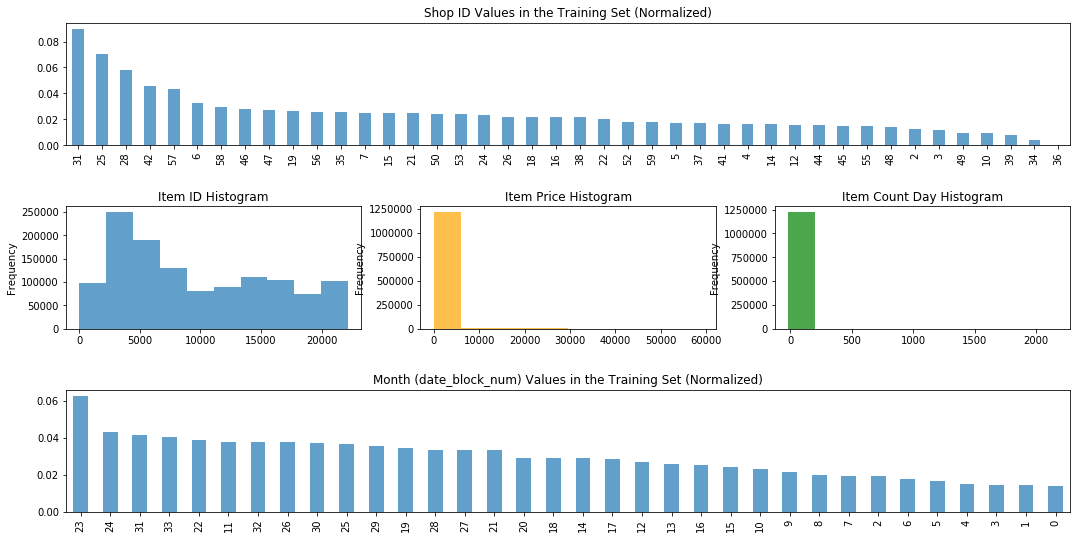

In [60]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

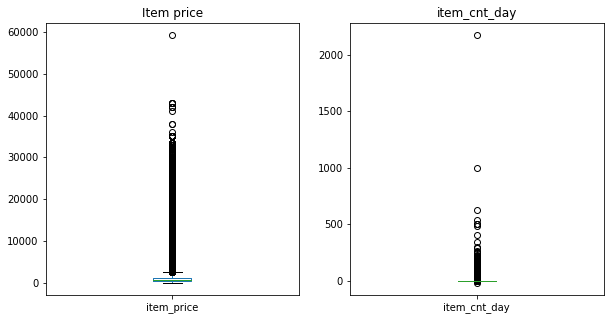

In [61]:
fig = plt.figure(figsize=(10,5))

plt.subplot2grid((1,2), (0,0))
train['item_price'].plot(kind='box')
plt.title('Item price')

plt.subplot2grid((1,2), (0,1))
train['item_cnt_day'].plot(kind='box')
plt.title('item_cnt_day')

plt.show()

In [73]:
train['item_cnt_day'].max()

2169.0

In [83]:
is_max=train['item_cnt_day']==2169.0
max=train[is_max]
max

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [86]:
A=items['item_id']==11373
A_=items[A]
A_

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


> ### 1.3 Feature Creation

month

In [33]:
train['month']=train['date_block_num']

In [34]:
train['month']+=1
train['month']%=12
print('shape of train',train.shape)

shape of train (1224429, 7)


In [35]:
train['month']

0           1
10          1
11          1
12          1
13          1
           ..
2935844    10
2935845    10
2935846    10
2935847    10
2935848    10
Name: month, Length: 1224429, dtype: int64

season

In [36]:
#season
train['season']=train['month']

In [37]:
train['season']//=3

In [38]:
train['season']=train['season'].replace(0,4)

area

In [39]:
#area
train=pd.merge(train,shops,how='left',on='shop_id')

In [40]:
area = train['shop_name'].apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0]) 
train['area'] = pd.Categorical(area).codes 
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,season,shop_name,area
0,02.01.2013,0,59,22154,999.0,1.0,1,4,"Ярославль ТЦ ""Альтаир""",27
1,03.01.2013,0,25,2574,399.0,2.0,1,4,"Москва ТРК ""Атриум""",12
2,05.01.2013,0,25,2574,399.0,1.0,1,4,"Москва ТРК ""Атриум""",12
3,07.01.2013,0,25,2574,399.0,1.0,1,4,"Москва ТРК ""Атриум""",12
4,08.01.2013,0,25,2574,399.0,2.0,1,4,"Москва ТРК ""Атриум""",12


In [41]:
train.shape

(1224429, 10)

discount rate

In [42]:
price_max = train.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
price_max.head()

,item_id,item_max_price
0,30,399.0
1,31,699.0
2,32,349.0
3,33,499.0
4,38,2399.0


In [43]:
price = train.groupby(['item_id']).mean()['item_price'].reset_index()
price.rename(columns={'item_price':'item_mean_price'}, inplace=True)
price.head()

,item_id,item_mean_price
0,30,324.562531
1,31,573.793088
2,32,250.083706
3,33,249.273016
4,38,2351.537037


In [44]:
train_price_dc = pd.merge(price, price_max, on=['item_id'], how='left') 
train_price_dc['discount'] = 1 - (train_price_dc['item_mean_price'] / train_price_dc['item_max_price']) 
train_price_dc.drop('item_max_price', axis=1, inplace=True) 
train_price_dc.head()

,item_id,item_mean_price,discount
0,30,324.562531,0.186560
1,31,573.793088,0.179123
2,32,250.083706,0.283428
3,33,249.273016,0.500455
4,38,2351.537037,0.019784


In [45]:
train=pd.merge(train,train_price_dc,how='left',on='item_id')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,season,shop_name,area,item_mean_price,discount
0,02.01.2013,0,59,22154,999.0,1.0,1,4,"Ярославль ТЦ ""Альтаир""",27,678.166667,0.321154
1,03.01.2013,0,25,2574,399.0,2.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521
2,05.01.2013,0,25,2574,399.0,1.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521
3,07.01.2013,0,25,2574,399.0,1.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521
4,08.01.2013,0,25,2574,399.0,2.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521


item_cnt_month

In [46]:
item_cnt_month = train.groupby(['item_id','shop_id','month']).sum()['item_cnt_day'].reset_index()
item_cnt_month.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)
item_cnt_month

,item_id,shop_id,month,item_cnt_month
0,30,2,3,1.0
1,30,2,4,1.0
2,30,2,5,1.0
3,30,2,6,1.0
4,30,3,0,2.0
...,...,...,...,...
479586,22167,58,3,1.0
479587,22167,58,9,1.0
479588,22167,59,0,2.0
479589,22167,59,6,1.0


In [47]:
train=pd.merge(train,item_cnt_month,how='left',on=['item_id','shop_id','month'])

In [48]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,season,shop_name,area,item_mean_price,discount,item_cnt_month
0,02.01.2013,0,59,22154,999.0,1.0,1,4,"Ярославль ТЦ ""Альтаир""",27,678.166667,0.321154,1.0
1,03.01.2013,0,25,2574,399.0,2.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521,21.0
2,05.01.2013,0,25,2574,399.0,1.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521,21.0
3,07.01.2013,0,25,2574,399.0,1.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521,21.0
4,08.01.2013,0,25,2574,399.0,2.0,1,4,"Москва ТРК ""Атриум""",12,405.213191,0.097521,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224424,10.10.2015,33,25,7409,299.0,1.0,10,3,"Москва ТРК ""Атриум""",12,295.482353,0.011765,3.0
1224425,09.10.2015,33,25,7460,299.0,1.0,10,3,"Москва ТРК ""Атриум""",12,294.940885,0.013576,3.0
1224426,14.10.2015,33,25,7459,349.0,1.0,10,3,"Москва ТРК ""Атриум""",12,308.576299,0.115827,1.0
1224427,22.10.2015,33,25,7440,299.0,1.0,10,3,"Москва ТРК ""Атриум""",12,299.000000,0.000000,1.0


In [30]:
del train['date']

In [31]:
del train['shop_name']

## 2. Modeling

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [33]:
X = train.iloc[:, 0:10]
Y = train.iloc[:, 10]

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0)

### 2.1 SVC

In [ ]:
svc = SVC(C = 1000, gamma = 0.00001)
svc.fit(x_train, y_train)

In [ ]:
print("prediction :", svc.predict(x_test))
print("train accuracy :", svc.score(x_train, y_train))
print("test accuracy :", svc.score(x_test, y_test))

### 2.2 Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=0)
forest.fit(x_train, y_train)
print("prediction :", forest.predict(x_test))
print("train accuracy :", forest.score(x_train, y_train))
print("test accuracy :", forest.score(x_test, y_test))

MemoryError: could not allocate 1790967808 bytes

In [75]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(x_train, y_train)

print("prediction :", forest.predict(x_test))
print("train accuracy :", forest.score(x_train, y_train))
print("test accuracy :", forest.score(x_test, y_test))

MemoryError: could not allocate 3581935616 bytes

### 2.3 Gradient Boosting Regression Tree

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0,max_depth=1)
gbrt.fit(x_train , y_train)
print("train accuracy :".format(gbrt.score(x_train,y_train)))
print("test accuracy :".format(gbrt.score(x_test,y_test)))

NameError: name 'x_train' is not defined

In [ ]:
print("train accuracy :".format(gbrt.score(x_train,y_train)))
print("test accuracy :".format(gbrt.score(x_test,y_test)))

### 2.4 XGBoost

In [40]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(x_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(x_train, y_train), (x_test, y_test)], 
              verbose=20, 
              early_stopping_rounds=20)

C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:81.3593	validation_1-rmse:82.0905
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:42.2695	validation_1-rmse:41.9142
[40]	validation_0-rmse:36.3878	validation_1-rmse:35.4296
[60]	validation_0-rmse:34.6453	validation_1-rmse:33.6376
[80]	validation_0-rmse:32.844	validation_1-rmse:31.7362
[100]	validation_0-rmse:31.8622	validation_1-rmse:30.7558
[120]	validation_0-rmse:31.0159	validation_1-rmse:29.9052
[140]	validation_0-rmse:30.1293	validation_1-rmse:29.019
[160]	validation_0-rmse:29.2585	validation_1-rmse:28.135
[180]	validation_0-rmse:28.5688	validation_1-rmse:27.4236
[200]	validation_0-rmse:27.9284	validation_1-rmse:26.7895
[220]	validation_0-rmse:27.3212	validation_1-rmse:26.1884
[240]	validation_0-rmse:26.916	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

In [43]:
xgb_train_pred = xgb_model.predict(x_train)
xgb_test_pred = xgb_model.predict(x_test)

In [48]:
xgb_train_pred = xgb_model.predict(test)

ValueError: feature_names mismatch: ['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'month', 'season', 'area', 'item_mean_price', 'discount'] ['ID', 'shop_id', 'item_id']
expected season, area, discount, month, item_cnt_day, date_block_num, item_price, item_mean_price in input data
training data did not have the following fields: ID